In [1]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/afs/cern.ch/user/j/jcapotor/FBGana/src')
sys.path.insert(1, '/afs/cern.ch/user/j/jcapotor/FBGana/ana_tools')
import manage_data
import getters
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.mlab as mlab

In [30]:
path_to_split = "/eos/user/j/jcapotor/FBGana/camara_climatica/FebruaryRuns/20230222/"
plt.style.use('./presentation.mplstyle')

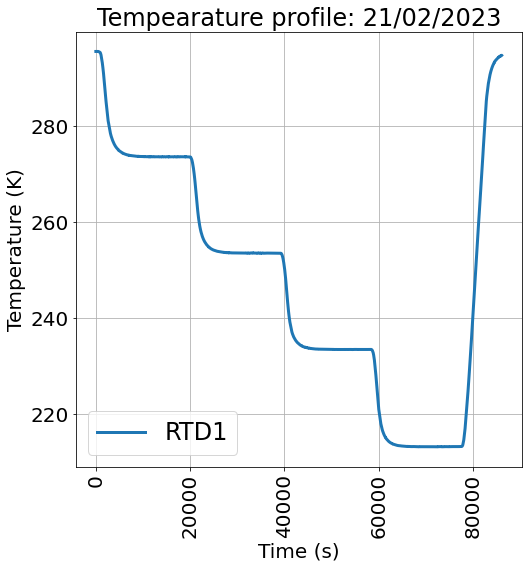

In [31]:
plt.figure(figsize=(8,8))
tp = pd.read_csv(path_to_split + "temperature.txt", header=0)
t0 = tp["Timestamp"][0]
plt.plot((tp["Timestamp"]-t0), tp["T1"], label="RTD1")
plt.title("Tempearature profile: 21/02/2023")
plt.xlabel("Time (s)")
plt.xticks(
    rotation=90
    )
plt.ylabel("Temperature (K)")
plt.legend()

In [39]:
pp = getters.get_data(path_to_split=path_to_split, pol="P")
specs = pd.read_csv(path_to_split + "P_spectrums.txt", header=0)

In [40]:
specs = specs.loc[(specs["Wav1-1"]>1532)]
pp = pp.loc[(pp["Wav1-1"]*1e9 >1532)]

specs, pp = manage_data.match_dataframes(specs, pp)
specs, temp = manage_data.match_datafrbinames(specs, tp)
pp, temp = manage_data.match_dataframes(pp, temp)

Index(['Unnamed: 0', 'Timestamp', 'Baseline', 'Baseline_err', 'Wav1-1',
       'Wav1-1_err', 'Wav1-1_fwhm', 'Wav1-1_fwhm_err', 'Wav1-1_sigma',
       'Wav1-1_sigma_err', 'Wav1-1_amp', 'Wav1-1_amp_err', 'Wav1-2',
       'Wav1-2_err', 'Wav1-2_fwhm', 'Wav1-2_fwhm_err', 'Wav1-2_sigma',
       'Wav1-2_sigma_err', 'Wav1-2_amp', 'Wav1-2_amp_err', 'Wav1-3',
       'Wav1-3_err', 'Wav1-3_fwhm', 'Wav1-3_fwhm_err', 'Wav1-3_sigma',
       'Wav1-3_sigma_err', 'Wav1-3_amp', 'Wav1-3_amp_err', 'Wav1-4',
       'Wav1-4_err', 'Wav1-4_fwhm', 'Wav1-4_fwhm_err', 'Wav1-4_sigma',
       'Wav1-4_sigma_err', 'Wav1-4_amp', 'Wav1-4_amp_err', 'Wav1-5',
       'Wav1-5_err', 'Wav1-5_fwhm', 'Wav1-5_fwhm_err', 'Wav1-5_sigma',
       'Wav1-5_sigma_err', 'Wav1-5_amp', 'Wav1-5_amp_err', 'Wav2-1',
       'Wav2-1_err', 'Wav2-1_fwhm', 'Wav2-1_fwhm_err', 'Wav2-1_sigma',
       'Wav2-1_sigma_err', 'Wav2-1_amp', 'Wav2-1_amp_err', 'Wav2-2',
       'Wav2-2_err', 'Wav2-2_fwhm', 'Wav2-2_fwhm_err', 'Wav2-2_sigma',
       'Wav2-2_si

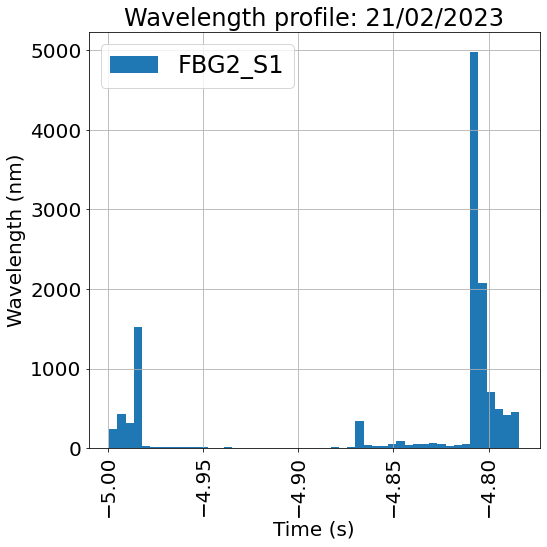

In [53]:
plt.figure(figsize=(8,8))
print(specs.columns)
plt.hist(specs["Wav1-1"] - specs["Wav1-2"], bins=50, label="FBG2_S1")
# plt.plot(specs["Timestamp"]-t0, pp["Wav1-1"]*1e9 - pp["Wav1-2"]*1e9, label="FBG2_S1")
# plt.plot(specs["Timestamp"]-t0, specs["Wav2-1"] - specs["Wav2-2"], label="FBG2_S1")
# plt.plot(pp["Timestamp"]-t0, pp["Wav1-2"]*1e9 - pp["Wav1-3"]*1e9, label="FBG2_S1")
plt.title("Wavelength profile: 21/02/2023")
plt.xlabel("Time (s)")
plt.xticks(
    rotation=90
    )
plt.ylabel("Wavelength (nm)")
plt.legend()
plt.tight_layout()

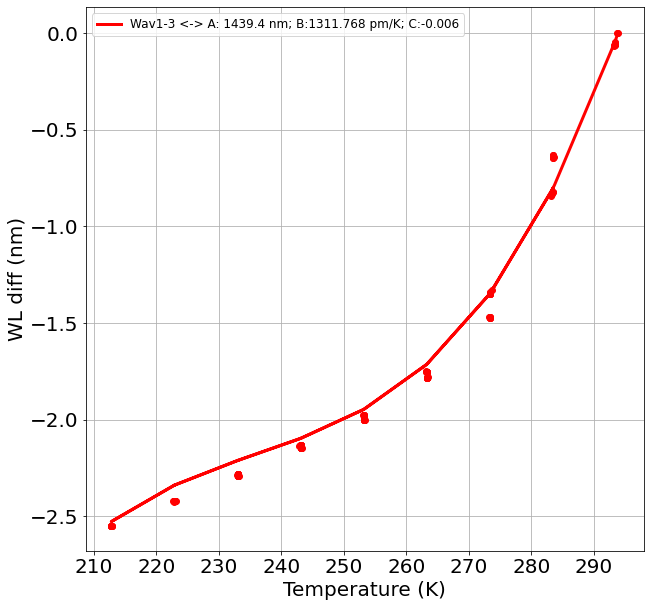

In [128]:
from scipy.optimize import curve_fit
from matplotlib.pyplot import cm

def line(x, A, B, C, D):
    return A + B*x + C*x**2 + D*x**3

plt.figure(figsize=(10,10))
sensors = ["Wav1-1", "Wav1-2", "Wav1-3", "Wav1-4", "Wav1-5", "Wav2-1", "Wav2-2", "Wav2-3", "Wav2-4"]
color = cm.rainbow(np.linspace(0, 1, len(sensors)))
for j in range(2,3):
    npoints = 100
    step = len(tp)/npoints
    xpoints, xerr = [], []
    ypoints, yerr = [], []
    for i in range(0, 2*npoints):    
        temp = (tp.loc[(tp["Timestamp"]-t0 > (step*i)) & (tp["Timestamp"]-t0 < (step + step*i))])
        if step*i < len(temp)/2:
            color="blue"
        else:
            color="red"
        peaks_p, temp = manage_data.match_dataframes(pp, temp)
        if np.std(temp["T2"])*1e3 > 1e2 or np.isnan(np.std(temp["T2"])*1e3):
            continue
        # plt.plot(peaks_p["Timestamp"] - t0, peaks_p[sensors[j]]*1e9, color="blue")
        xpoints.append(np.mean(temp["T2"]))
        xerr.append(np.std(temp["T2"]))
        ypoints.append(np.mean(peaks_p[sensors[j]])*1e9)
        yerr.append(np.std(peaks_p[sensors[j]])*1e9)

    popt, pcov = curve_fit(line, xdata=xpoints, ydata=ypoints, sigma=yerr)

    # plt.figure(figsize=(8,8))
    plt.plot(xpoints,
        line(np.array(xpoints), popt[0], popt[1], popt[2], popt[3]) - line(np.array(xpoints), popt[0], popt[1], popt[2], popt[3])[0],
        label=r"{0:} <-> A: {1:.1f} nm; B:{2:.3f} pm/K; C:{3:.3f}".format(sensors[j], popt[0], popt[1]*1e3, popt[2]),
        color="green"
        )
    plt.errorbar(
        xpoints, ypoints - ypoints[0],
        xerr=xerr, yerr=yerr,
        fmt="o",
        color=color
    )
plt.ylabel("WL diff (nm)")
plt.xlabel("Temperature (K)")
plt.legend(fontsize=12)
